<a href="https://colab.research.google.com/github/PascalLiPooKim/Football-prediction-model-project/blob/data-wrangling/footballPredictionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import missingno as msn

# Team Info

In [2]:
team_info_df = pd.read_csv('https://raw.githubusercontent.com/PascalLiPooKim/Football-prediction-model-project/data-wrangling/Football_Data/Football_Data/Team_Info.csv')
team_info_df.head()

,Team,City,Country,Stadium,Capacity,Pitch
0,Wattenscheid 09,Bochum-Wattenscheid,Germany,Lohrheidestadion,16233,Natural
1,Hertha BSC,Berlín,Germany,Olympiastadion Berlin,76065,Natural
2,Unterhaching,Unterhaching,Germany,Sportpark Unterhaching,15053,Natural
3,Fortuna Köln,Cologne,Germany,Südstadion,14944,Natural
4,MSV Duisburg,Duisburgo,Germany,Schauinsland-Reisen-Arena,31514,Natural


In [3]:
team_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Team      544 non-null    object
 1   City      544 non-null    object
 2   Country   544 non-null    object
 3   Stadium   447 non-null    object
 4   Capacity  544 non-null    object
 5   Pitch     447 non-null    object
dtypes: object(6)
memory usage: 25.6+ KB


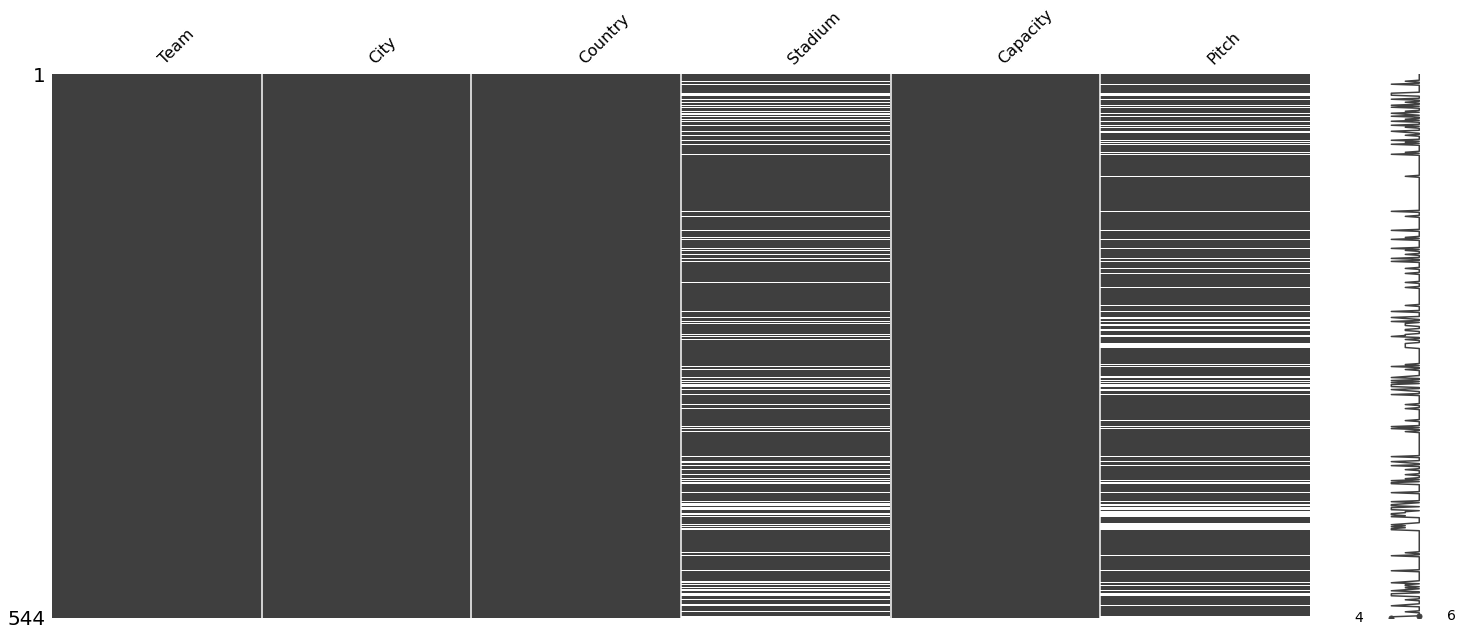

In [4]:
msn.matrix(team_info_df)

In [5]:
team_info_df.isnull().sum()/len(team_info_df)

Team        0.000000
City        0.000000
Country     0.000000
Stadium     0.178309
Capacity    0.000000
Pitch       0.178309
dtype: float64

In [6]:
team_info_cols_with_null = ['Stadium', 'Pitch']
for col in team_info_cols_with_null:
  print(team_info_df[col].value_counts()/len(team_info_df))
  # print(team_info_df[col].unique())
  # print(team_info_df[team_info_df[col].isnull()])

Cartagonova                       0.003676
Stadio Città del Tricolore        0.003676
Stadio Marc'Antonio Bentegodi     0.003676
Stadio Atleti Azzurri d'Italia    0.003676
Cerro del Espino                  0.003676
                                    ...   
Mestalla                          0.001838
Stade de Sauclières               0.001838
Deepdale Stadium                  0.001838
Stadio Libero Liberati            0.001838
Vicarage Road Stadium             0.001838
Name: Stadium, Length: 442, dtype: float64
Natural              0.648897
Grass                0.055147
Césped natural       0.038603
Césped Artificial    0.029412
grass                0.014706
Césped Natural       0.011029
natural              0.003676
Césped               0.003676
Artificial           0.003676
cesped real          0.001838
cesped natural       0.001838
Cesped natural       0.001838
Natural grass        0.001838
natural grass        0.001838
AirFibr              0.001838
NATURAL              0.001838
Name

In [7]:
team_info_df['Stadium'].unique()

array(['Lohrheidestadion', 'Olympiastadion Berlin',
       'Sportpark Unterhaching', 'Südstadion',
       'Schauinsland-Reisen-Arena', 'Stadion Ludwigspark',
       'Eintracht-Stadion', nan, 'osnatel-ARENA', 'MEP-Arena',
       'VELTINS-Arena', 'Stadion Essen', 'Schwarzwald-Stadion',
       'Neuer Tivoli', 'Merck-Stadion am Böllenfalltor', 'HDI-Arena',
       'GAZİ-Stadion auf der Waldau', 'Preußen-Stadion', 'Opel Arena',
       'Marschwegstadion', 'Wilhelm-Langrehr-Stadion', 'ERDGAS Sportpark',
       'Ernst-Abbe-Sportfeld', 'Steigerwaldstadion', 'Grünwalder Stadion',
       'Volkswagen-Arena', 'DKB Arena', 'Millerntor-Stadion',
       'ESPRIT arena', 'rewirpowerSTADION',
       'Frankfurter Volksbank Stadion', 'Grundig-Stadion', 'SchücoArena',
       'Commerzbank-Arena', 'Fritz-Walter-Stadion',
       'Sportpark Ronhof Thomas Sommer',
       'Stadion der Freundschaft, Cottbus', 'RheinEnergieStadion',
       'Stadion Niederrhein', 'Wildparkstadion', 'Bieberer Berg Stadion',
       'Bo

In [8]:
team_info_df['Country'].unique()

array(['Germany', 'England', 'Netherlands', 'France', 'Portugal', 'Spain',
       'Italy'], dtype=object)

In [9]:
england_teams = team_info_df[team_info_df['Country'] == 'England']
# 'Charlton Athletic' in england_teams
england_teams

,Team,City,Country,Stadium,Capacity,Pitch
87,West Ham,Londres,England,London Stadium,80000,Natural
88,Blackburn Rovers,Blackburn,England,Ewood Park,31367,Natural
89,Sheffield United,Sheffield,England,Bramall Lane,32702,Natural
90,Ipswich Town,Ipswich,England,Portman Road Stadium,30311,Natural
91,Sunderland,Sunderland,England,Stadium of Light,49000,Natural
...,...,...,...,...,...,...
278,Aston Villa,Birmingham,England,Villa Park,42788,Natural
279,Southampton,Southampton,England,St. Mary's Stadium,32689,Natural
280,Everton,Liverpool,England,Goodison Park,40569,Natural
281,Arsenal,Londres,England,Emirates Stadium,60355,Natural


In [10]:
team_info_df['Pitch'].unique()

array(['Natural', 'grass', 'Césped', nan, 'cesped natural', 'Grass',
       'cesped real', 'NATURAL', 'Césped Artificial', 'AirFibr ',
       'Natural grass', 'Césped Natural', 'Cesped natural',
       'Césped natural', 'natural grass', 'Artificial', 'natural'],
      dtype=object)

In [11]:
import itertools
replace_from = ['Natural', 'grass', 'natural', 'natural grass', 'NATURAL', 'Natural grass']
replace_to = ['Natural Grass']
to_replace = dict(itertools.product(replace_from, replace_to))

replace_from = ['Cesped natural', 'cesped natural', 'Césped natural', 'cesped real']
replace_to = ['Césped Natural']
to_replace.update(dict(itertools.product(replace_from, replace_to)))

replace_from = ['AirFibr ', 'Artificial']
replace_to = ['Césped Artificial']
to_replace.update(dict(itertools.product(replace_from, replace_to)))

team_info_df['Pitch'].replace(to_replace=to_replace, inplace=True)
team_info_df['Pitch'].unique()

array(['Natural Grass', 'Césped', nan, 'Césped Natural', 'Grass',
       'Césped Artificial'], dtype=object)

In [12]:
def categories_encoder_decoder(df, cols_with_null):
  category_dict_encode = {}
  category_dict_decode = {}
  for col in cols_with_null:
      # le = LabelEncoder()
      df[col] = df[col].astype('category')
      # le.fit(team_info_df[col])
      # team_info_df[col] = le.transform(team_info_df[col])
      # print(le.classes_)
      categories = team_info_df[col].cat.categories
      
      col_cat_dict = dict(enumerate(categories))
      # print("Column, Category dict:", col_cat_dict)
      category_dict_decode[col] = col_cat_dict
      
      col_cat_dict = {v:k for k,v in col_cat_dict.items()}
      # print("Inverted Column, Category dict:", col_cat_dict)
      category_dict_encode[col] = col_cat_dict

  return category_dict_encode, category_dict_decode

In [13]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

category_dict_encode, category_dict_decode = categories_encoder_decoder(team_info_df, ['Pitch'])

print("Category dict ENCODE:", category_dict_encode)
print("Category dict DECODE:", category_dict_decode)
team_info_df.replace(category_dict_encode, inplace=True)
team_info_df

Category dict ENCODE: {'Pitch': {'Césped': 0, 'Césped Artificial': 1, 'Césped Natural': 2, 'Grass': 3, 'Natural Grass': 4}}
Category dict DECODE: {'Pitch': {0: 'Césped', 1: 'Césped Artificial', 2: 'Césped Natural', 3: 'Grass', 4: 'Natural Grass'}}


,Team,City,Country,Stadium,Capacity,Pitch
0,Wattenscheid 09,Bochum-Wattenscheid,Germany,Lohrheidestadion,16233,4.0
1,Hertha BSC,Berlín,Germany,Olympiastadion Berlin,76065,4.0
2,Unterhaching,Unterhaching,Germany,Sportpark Unterhaching,15053,4.0
3,Fortuna Köln,Cologne,Germany,Südstadion,14944,4.0
4,MSV Duisburg,Duisburgo,Germany,Schauinsland-Reisen-Arena,31514,4.0
...,...,...,...,...,...,...
539,Latina,Latina,Italy,Stadio Comunale Domenico Francioni,8000,4.0
540,Virtus Entella,Chiavari,Italy,Stadio Comunale Chiavari,4154,1.0
541,Nuova Cosenza,Cosenza,Italy,Stadio San Vito,24209,4.0
542,Pordenone,Pordenone,Italy,NaN,3089,NaN


In [14]:
# knn_impute = KNNImputer(n_neighbors=3, weights="distance")
# knn_team_info_arr = knn_impute.fit_transform(team_info_df[team_info_cols_with_null])
# knn_team_info_df = pd.DataFrame(knn_team_info_arr.astype('int64'), columns = team_info_df[team_info_cols_with_null].columns)
# knn_team_info_df

In [15]:
# knn_team_info_df.replace(category_dict_decode, inplace=True)
# knn_team_info_df

# Match Info

In [16]:
match_info_df = pd.read_csv('https://raw.githubusercontent.com/PascalLiPooKim/Football-prediction-model-project/data-wrangling/Football_Data/Football_Data/Match_Info.csv')
match_info_df.head()

,Link,Date_New,Referee,Home_Yellow,Home_Red,Away_Yellow,Away_Red
0,/match/saarbrucken/stuttgarter-kickers/1990,"Saturday, 29 July 1989, 15:00",\nReferee: Hans-Jürgen Weber\n,0.0,0.0,3.0,0.0
1,/match/sc-freiburg/unterhaching/1990,"Saturday, 29 July 1989, 15:00",\nReferee: Kurt Wittke\n,1.0,0.0,0.0,0.0
2,/match/vfl-osnabruck/meppen/1990,"Saturday, 29 July 1989, 15:00",\nReferee: Werner Föckler\n,3.0,0.0,2.0,0.0
3,/match/rot-weiss-essen/schalke-04/1990,"Saturday, 29 July 1989, 15:00",\nReferee: Heinz Werner\n,2.0,0.0,2.0,0.0
4,/match/alemannia-aachen/msv-duisburg/1990,"Saturday, 29 July 1989, 15:00",\nReferee: Hans-Peter Dellwing\n,1.0,0.0,1.0,0.0


In [17]:
match_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143348 entries, 0 to 143347
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Link         143348 non-null  object 
 1   Date_New     143348 non-null  object 
 2   Referee      143348 non-null  object 
 3   Home_Yellow  122798 non-null  float64
 4   Home_Red     122798 non-null  float64
 5   Away_Yellow  122798 non-null  float64
 6   Away_Red     122798 non-null  float64
dtypes: float64(4), object(3)
memory usage: 7.7+ MB


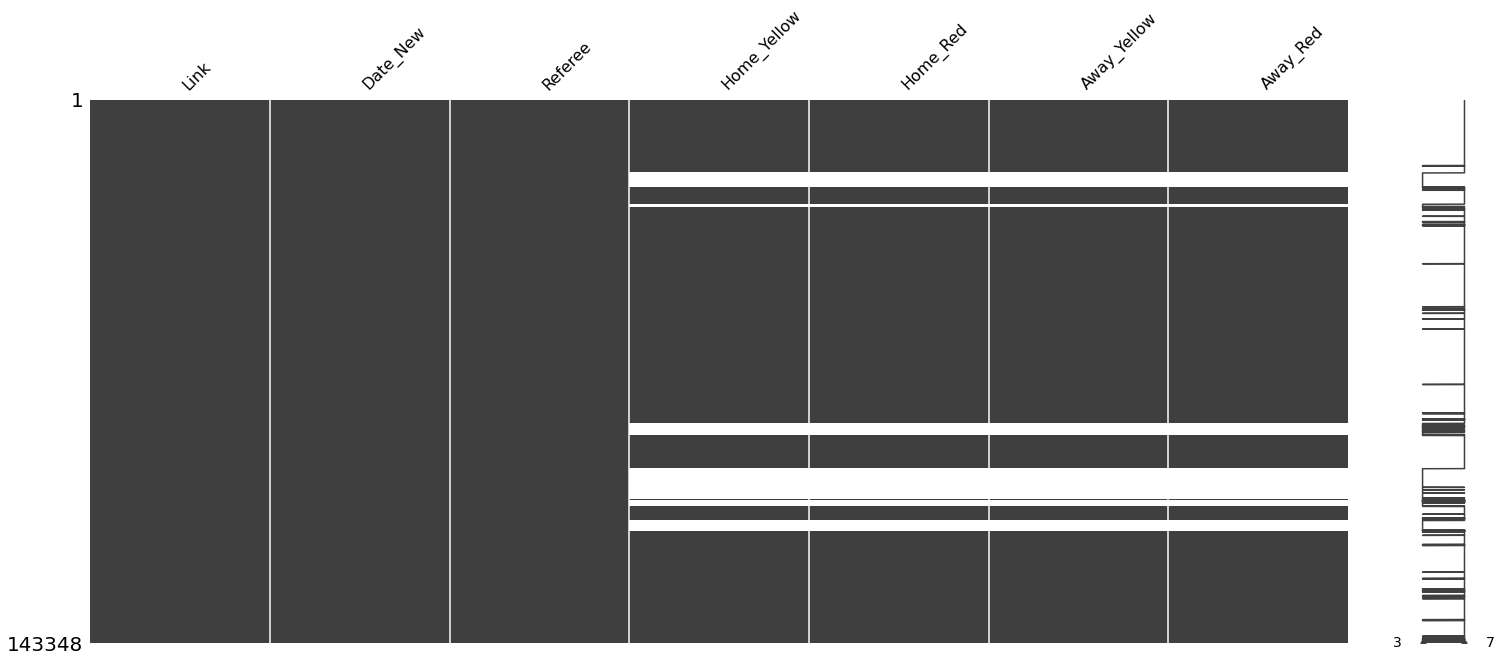

In [18]:
msn.matrix(match_info_df)

In [19]:
match_info_df.isnull().sum()/len(match_info_df)

Link           0.000000
Date_New       0.000000
Referee        0.000000
Home_Yellow    0.143357
Home_Red       0.143357
Away_Yellow    0.143357
Away_Red       0.143357
dtype: float64

In [20]:
match_info_cols_with_null = ['Home_Yellow', 'Home_Red', 'Away_Yellow', 'Away_Red']
match_info_cols_with_null

['Home_Yellow', 'Home_Red', 'Away_Yellow', 'Away_Red']

In [21]:
import numpy as np

for col in match_info_cols_with_null:
  print(match_info_df[col].unique())
  match_info_df[col].replace(to_replace={np.nan: 0}, inplace=True)
  print(match_info_df[col].unique())

[ 0.  1.  3.  2.  4.  5.  6.  7.  8. nan  9. 10.]
[ 0.  1.  3.  2.  4.  5.  6.  7.  8.  9. 10.]
[ 0.  1.  3.  2. nan]
[0. 1. 3. 2.]
[ 3.  0.  2.  1.  4.  6.  5.  8.  7.  9. nan 10.]
[ 3.  0.  2.  1.  4.  6.  5.  8.  7.  9. 10.]
[ 0.  1.  2.  3. nan  4.]
[0. 1. 2. 3. 4.]


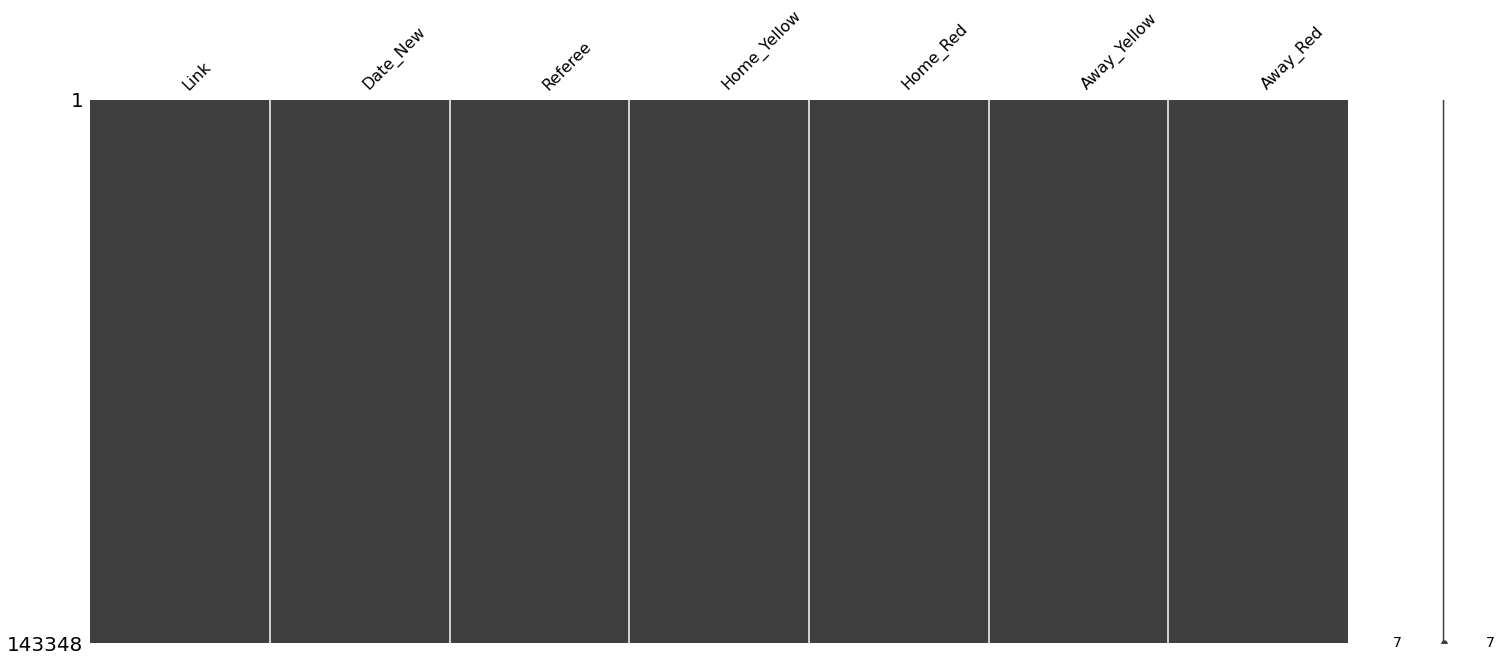

In [22]:
msn.matrix(match_info_df)

In [23]:
match_info_df['Date_New'] = pd.to_datetime(match_info_df['Date_New'])
match_info_df['Referee'] = match_info_df['Referee'].str.strip().str.split(':').str[-1]
match_info_df
# type(match_info_df['Referee'].str.strip().str.split(':'))

,Link,Date_New,Referee,Home_Yellow,Home_Red,Away_Yellow,Away_Red
0,/match/saarbrucken/stuttgarter-kickers/1990,1989-07-29 15:00:00,Hans-Jürgen Weber,0.0,0.0,3.0,0.0
1,/match/sc-freiburg/unterhaching/1990,1989-07-29 15:00:00,Kurt Wittke,1.0,0.0,0.0,0.0
2,/match/vfl-osnabruck/meppen/1990,1989-07-29 15:00:00,Werner Föckler,3.0,0.0,2.0,0.0
3,/match/rot-weiss-essen/schalke-04/1990,1989-07-29 15:00:00,Heinz Werner,2.0,0.0,2.0,0.0
4,/match/alemannia-aachen/msv-duisburg/1990,1989-07-29 15:00:00,Hans-Peter Dellwing,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
143343,/match/sunderland-afc/oxford-city/1999,1998-09-19 00:00:00,Anthony Leake,1.0,0.0,0.0,0.0
143344,/match/fc-gueugnon/bastia/1994,1994-05-17 00:00:00,Jacques Poulain,0.0,0.0,0.0,0.0
143345,/match/tranmere-rovers/wolverhampton/1999,1999-01-08 00:00:00,Kevin Lynch,2.0,0.0,1.0,0.0
143346,/match/sochaux/guingamp/2021,2021-02-27 19:00:00,Baert A.,0.0,0.0,2.0,0.0


# Results

## Premier League

In [24]:
pl_1990 = pd.read_csv('https://raw.githubusercontent.com/PascalLiPooKim/Football-prediction-model-project/data-wrangling/Football_Data/Football_Data/Results/premier_league/Results_1990_premier_league.csv')
pl_1990.head()

,Home_Team,Away_Team,Result,Link,Season,Round,League
0,Charlton Athletic,Derby County,0-0,https://www.besoccer.com/match/charlton-athlet...,1990,1,premier_league
1,Tottenham Hotspur,Luton Town,2-1,https://www.besoccer.com/match/tottenham-hotsp...,1990,1,premier_league
2,Southampton,Millwall,1-2,https://www.besoccer.com/match/southampton-fc/...,1990,1,premier_league
3,Sheffield Wednesday,Norwich City,0-2,https://www.besoccer.com/match/sheffield-wedne...,1990,1,premier_league
4,Queens Park Rangers,Crystal Palace,2-0,https://www.besoccer.com/match/queens-park-ran...,1990,1,premier_league


In [25]:
pl_1990.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Home_Team  380 non-null    object
 1   Away_Team  380 non-null    object
 2   Result     380 non-null    object
 3   Link       380 non-null    object
 4   Season     380 non-null    int64 
 5   Round      380 non-null    int64 
 6   League     380 non-null    object
dtypes: int64(2), object(5)
memory usage: 20.9+ KB


In [26]:
results_pl = []
for season in range(1990, 2022):
  df = pd.read_csv(f'https://raw.githubusercontent.com/PascalLiPooKim/Football-prediction-model-project/data-wrangling/Football_Data/Football_Data/Results/premier_league/Results_{season}_premier_league.csv')
  df.info()
  results_pl.append(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Home_Team  380 non-null    object
 1   Away_Team  380 non-null    object
 2   Result     380 non-null    object
 3   Link       380 non-null    object
 4   Season     380 non-null    int64 
 5   Round      380 non-null    int64 
 6   League     380 non-null    object
dtypes: int64(2), object(5)
memory usage: 20.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380 entries, 0 to 379
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Home_Team  380 non-null    object
 1   Away_Team  380 non-null    object
 2   Result     380 non-null    object
 3   Link       380 non-null    object
 4   Season     380 non-null    int64 
 5   Round      380 non-null    int64 
 6   League     380 non-null    object
dtypes: int64(2), object(5)
memory usag

In [27]:
pl_df = pd.concat(results_pl).reset_index().drop(labels=['index'], axis = 1)
pl_df.head()

,Home_Team,Away_Team,Result,Link,Season,Round,League
0,Charlton Athletic,Derby County,0-0,https://www.besoccer.com/match/charlton-athlet...,1990,1,premier_league
1,Tottenham Hotspur,Luton Town,2-1,https://www.besoccer.com/match/tottenham-hotsp...,1990,1,premier_league
2,Southampton,Millwall,1-2,https://www.besoccer.com/match/southampton-fc/...,1990,1,premier_league
3,Sheffield Wednesday,Norwich City,0-2,https://www.besoccer.com/match/sheffield-wedne...,1990,1,premier_league
4,Queens Park Rangers,Crystal Palace,2-0,https://www.besoccer.com/match/queens-park-ran...,1990,1,premier_league


In [28]:
pl_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12417 entries, 0 to 12416
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Home_Team  12417 non-null  object
 1   Away_Team  12417 non-null  object
 2   Result     12417 non-null  object
 3   Link       12417 non-null  object
 4   Season     12417 non-null  int64 
 5   Round      12417 non-null  int64 
 6   League     12417 non-null  object
dtypes: int64(2), object(5)
memory usage: 679.2+ KB


In [29]:
pl_df.isnull().sum()/len(pl_df)

Home_Team    0.0
Away_Team    0.0
Result       0.0
Link         0.0
Season       0.0
Round        0.0
League       0.0
dtype: float64

In [30]:
pl_df['Result'].unique()

array(['0-0', '2-1', '1-2', '0-2', '2-0', '1-1', '4-1', '3-1', '0-1',
       '2-2', '1-0', '3-0', '4-0', '9-0', '0-3', '5-0', '4-4', '3-2',
       '1-4', '5-1', '1-3', '4-3', '6-2', '6-0', '2-3', '6-3', '2-5',
       '4-2', '2-4', '3-3', '0-4', '1-6', '6-1', '1-5', '4-6', '2-6',
       '3-4', '1-7', '4-5', '7-0', '5-2', '3-5', '3-6', '7-1', '5-3',
       '0-5', '0-6', '7-2', '1-8', '8-0', '5-4', '7-4', '6-4', '8-1',
       '9-1', '8-2', '7-3', '5-5', '0-9', '0-7', '17 JAN'], dtype=object)

In [31]:
print(pl_df[pl_df['Result'] == '17 JAN'])
pl_df = pl_df[pl_df['Result'] != '17 JAN']
pl_df

         Home_Team Away_Team  Result  ... Season  Round          League
12293  Aston Villa   Everton  17 JAN  ...   2021     19  premier_league

[1 rows x 7 columns]


,Home_Team,Away_Team,Result,Link,Season,Round,League
0,Charlton Athletic,Derby County,0-0,https://www.besoccer.com/match/charlton-athlet...,1990,1,premier_league
1,Tottenham Hotspur,Luton Town,2-1,https://www.besoccer.com/match/tottenham-hotsp...,1990,1,premier_league
2,Southampton,Millwall,1-2,https://www.besoccer.com/match/southampton-fc/...,1990,1,premier_league
3,Sheffield Wednesday,Norwich City,0-2,https://www.besoccer.com/match/sheffield-wedne...,1990,1,premier_league
4,Queens Park Rangers,Crystal Palace,2-0,https://www.besoccer.com/match/queens-park-ran...,1990,1,premier_league
...,...,...,...,...,...,...,...
12412,West Ham,Leicester,3-2,https://www.besoccer.com/match/west-ham-united...,2021,31,premier_league
12413,Tottenham Hotspur,Man. Utd,1-3,https://www.besoccer.com/match/tottenham-hotsp...,2021,31,premier_league
12414,Sheffield United,Arsenal,0-3,https://www.besoccer.com/match/sheffield-unite...,2021,31,premier_league
12415,West Bromwich Albion,Southampton,3-0,https://www.besoccer.com/match/west-bromwich/s...,2021,31,premier_league


In [32]:
def score_to_result(df, col):
  home_team_results = []
  for i, row in df.iterrows():
    ls = row[col].split('-')
    # print(ls)
    if int(ls[0]) > int(ls[1]):
      # print('Draw')
      home_team_results.append('Win')
    elif int(ls[0]) < int(ls[1]):
      home_team_results.append('Loss')
    else:
      home_team_results.append('Draw')
  return home_team_results

pl_df['Home_Team_Outcome'] = score_to_result(pl_df, 'Result')
pl_df

,Home_Team,Away_Team,Result,Link,Season,Round,League,Home_Team_Outcome
0,Charlton Athletic,Derby County,0-0,https://www.besoccer.com/match/charlton-athlet...,1990,1,premier_league,Draw
1,Tottenham Hotspur,Luton Town,2-1,https://www.besoccer.com/match/tottenham-hotsp...,1990,1,premier_league,Win
2,Southampton,Millwall,1-2,https://www.besoccer.com/match/southampton-fc/...,1990,1,premier_league,Loss
3,Sheffield Wednesday,Norwich City,0-2,https://www.besoccer.com/match/sheffield-wedne...,1990,1,premier_league,Loss
4,Queens Park Rangers,Crystal Palace,2-0,https://www.besoccer.com/match/queens-park-ran...,1990,1,premier_league,Win
...,...,...,...,...,...,...,...,...
12412,West Ham,Leicester,3-2,https://www.besoccer.com/match/west-ham-united...,2021,31,premier_league,Win
12413,Tottenham Hotspur,Man. Utd,1-3,https://www.besoccer.com/match/tottenham-hotsp...,2021,31,premier_league,Loss
12414,Sheffield United,Arsenal,0-3,https://www.besoccer.com/match/sheffield-unite...,2021,31,premier_league,Loss
12415,West Bromwich Albion,Southampton,3-0,https://www.besoccer.com/match/west-bromwich/s...,2021,31,premier_league,Win


In [33]:
unique_pl_teams = set()
unique_pl_teams.update(pl_df['Home_Team'])
unique_pl_teams.update(pl_df['Away_Team'])
unique_pl_teams

{'AFC Bournemouth',
 'Arsenal',
 'Aston Villa',
 'Barnsley',
 'Birmingham City',
 'Blackburn Rovers',
 'Blackpool',
 'Bolton Wanderers',
 'Bradford City',
 'Brighton & Hove Albion',
 'Burnley',
 'Cardiff City',
 'Charlton Athletic',
 'Chelsea',
 'Coventry City',
 'Crystal Palace',
 'Derby County',
 'Everton',
 'Fulham',
 'Huddersfield Town',
 'Hull City',
 'Ipswich Town',
 'Leeds United',
 'Leicester',
 'Liverpool',
 'Luton Town',
 'Man. City',
 'Man. Utd',
 'Middlesbrough',
 'Millwall',
 'Newcastle',
 'Norwich City',
 'Nottingham Forest',
 'Notts County',
 'Oldham Athletic AFC',
 'Portsmouth',
 'Queens Park Rangers',
 'Reading',
 'Sheffield United',
 'Sheffield Wednesday',
 'Southampton',
 'Stoke City',
 'Sunderland',
 'Swansea City',
 'Swindon Town',
 'Tottenham Hotspur',
 'Watford',
 'West Bromwich Albion',
 'West Ham',
 'Wigan Athletic',
 'Wimbledon FC',
 'Wolves'}

In [34]:
pl_df.columns

Index(['Home_Team', 'Away_Team', 'Result', 'Link', 'Season', 'Round', 'League',
       'Home_Team_Outcome'],
      dtype='object')

In [35]:
category_dict_encode = {}
category_dict_decode = {}
    

# print("Column, Category dict:", col_cat_dict)
for col in ['Home_Team', 'Away_Team']:
  col_cat_dict = dict(enumerate(unique_pl_teams))
  category_dict_decode[col] = col_cat_dict

  col_cat_dict = {v:k for k,v in col_cat_dict.items()}
  # print("Inverted Column, Category dict:", col_cat_dict)
  category_dict_encode[col] = col_cat_dict

# print()
print("Category dict ENCODE:", category_dict_encode)
# print("Category dict DECODE:", category_dict_decode)
pl_df.replace(category_dict_encode, inplace=True)
pl_df
# category_dict_encode['Away_Team']
# df = pl_df.replace(category_dict_encode)
# df

Category dict ENCODE: {'Home_Team': {'Chelsea': 0, 'Wigan Athletic': 1, 'Brighton & Hove Albion': 2, 'Wolves': 3, 'Birmingham City': 4, 'Notts County': 5, 'Man. Utd': 6, 'Coventry City': 7, 'Fulham': 8, 'Middlesbrough': 9, 'Blackburn Rovers': 10, 'Nottingham Forest': 11, 'Swindon Town': 12, 'Ipswich Town': 13, 'Burnley': 14, 'AFC Bournemouth': 15, 'Sunderland': 16, 'Stoke City': 17, 'Queens Park Rangers': 18, 'Southampton': 19, 'Wimbledon FC': 20, 'Bradford City': 21, 'Swansea City': 22, 'Sheffield United': 23, 'Barnsley': 24, 'Liverpool': 25, 'Arsenal': 26, 'Newcastle': 27, 'Watford': 28, 'Derby County': 29, 'Cardiff City': 30, 'Millwall': 31, 'Tottenham Hotspur': 32, 'Portsmouth': 33, 'Hull City': 34, 'Leeds United': 35, 'Charlton Athletic': 36, 'Oldham Athletic AFC': 37, 'Bolton Wanderers': 38, 'Huddersfield Town': 39, 'Reading': 40, 'Crystal Palace': 41, 'Aston Villa': 42, 'Sheffield Wednesday': 43, 'Everton': 44, 'Norwich City': 45, 'Man. City': 46, 'West Ham': 47, 'Leicester': 48

,Home_Team,Away_Team,Result,Link,Season,Round,League,Home_Team_Outcome
0,36,29,0-0,https://www.besoccer.com/match/charlton-athlet...,1990,1,premier_league,Draw
1,32,49,2-1,https://www.besoccer.com/match/tottenham-hotsp...,1990,1,premier_league,Win
2,19,31,1-2,https://www.besoccer.com/match/southampton-fc/...,1990,1,premier_league,Loss
3,43,45,0-2,https://www.besoccer.com/match/sheffield-wedne...,1990,1,premier_league,Loss
4,18,41,2-0,https://www.besoccer.com/match/queens-park-ran...,1990,1,premier_league,Win
...,...,...,...,...,...,...,...,...
12412,47,48,3-2,https://www.besoccer.com/match/west-ham-united...,2021,31,premier_league,Win
12413,32,6,1-3,https://www.besoccer.com/match/tottenham-hotsp...,2021,31,premier_league,Loss
12414,23,26,0-3,https://www.besoccer.com/match/sheffield-unite...,2021,31,premier_league,Loss
12415,50,19,3-0,https://www.besoccer.com/match/west-bromwich/s...,2021,31,premier_league,Win


In [36]:
one_hot_pl_df = pd.get_dummies(pl_df, columns=['Home_Team_Outcome', 'Home_Team', 'Away_Team']).drop(labels=['Result'], axis = 1)
one_hot_pl_df

,Link,Season,Round,League,Home_Team_Outcome_Draw,Home_Team_Outcome_Loss,Home_Team_Outcome_Win,Home_Team_0,Home_Team_1,Home_Team_2,Home_Team_3,Home_Team_4,Home_Team_5,Home_Team_6,Home_Team_7,Home_Team_8,Home_Team_9,Home_Team_10,Home_Team_11,Home_Team_12,Home_Team_13,Home_Team_14,Home_Team_15,Home_Team_16,Home_Team_17,Home_Team_18,Home_Team_19,Home_Team_20,Home_Team_21,Home_Team_22,Home_Team_23,Home_Team_24,Home_Team_25,Home_Team_26,Home_Team_27,Home_Team_28,Home_Team_29,Home_Team_30,Home_Team_31,Home_Team_32,...,Away_Team_12,Away_Team_13,Away_Team_14,Away_Team_15,Away_Team_16,Away_Team_17,Away_Team_18,Away_Team_19,Away_Team_20,Away_Team_21,Away_Team_22,Away_Team_23,Away_Team_24,Away_Team_25,Away_Team_26,Away_Team_27,Away_Team_28,Away_Team_29,Away_Team_30,Away_Team_31,Away_Team_32,Away_Team_33,Away_Team_34,Away_Team_35,Away_Team_36,Away_Team_37,Away_Team_38,Away_Team_39,Away_Team_40,Away_Team_41,Away_Team_42,Away_Team_43,Away_Team_44,Away_Team_45,Away_Team_46,Away_Team_47,Away_Team_48,Away_Team_49,Away_Team_50,Away_Team_51
0,https://www.besoccer.com/match/charlton-athlet...,1990,1,premier_league,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,https://www.besoccer.com/match/tottenham-hotsp...,1990,1,premier_league,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,https://www.besoccer.com/match/southampton-fc/...,1990,1,premier_league,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,https://www.besoccer.com/match/sheffield-wedne...,1990,1,premier_league,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,https://www.besoccer.com/match/queens-park-ran...,1990,1,premier_league,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12412,https://www.besoccer.com/match/west-ham-united...,2021,31,premier_league,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
12413,https://www.besoccer.com/match/tottenham-hotsp...,2021,31,premier_league,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12414,https://www.besoccer.com/match/sheffield-unite...,2021,31,premier_league,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12415,https://www.besoccer.com/match/west-bromwich/s...,2021,31,premier_league,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

ct = make_column_transformer(
    (OneHotEncoder(), ['Home_Team', 'Away_Team', 'Round'])
)

# ct_y = make_column_transformer(
#     (OneHotEncoder(), ['Home_Team_Outcome'])
# )

X = pl_df.drop('Home_Team_Outcome', axis = 1)
y = np.array(pl_df['Home_Team_Outcome'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

ct.fit(X_train)

y_encoder = LabelEncoder()
y_encoder.fit(y_train)
print(y_encoder.classes_)

X_train = ct.transform(X_train).toarray()
X_test = ct.transform(X_test).toarray()

y_train = y_encoder.transform(y_train)
y_test = y_encoder.transform(y_test)


X_train.shape


['Draw' 'Loss' 'Win']


(11174, 146)

# Models

## Logistic Regression

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

cv = KFold(n_splits=3, shuffle=True, random_state=1)
accs = {}
for train_ix, test_ix in cv.split(X_train):
  X_train_cv, X_test_cv = X_train[train_ix], X_train[test_ix]
  y_train_cv, y_test_cv = y_train[train_ix], y_train[test_ix]
  logReg = LogisticRegression(random_state=0, max_iter=1000)
  params = dict(C = np.logspace(-4, 4, 5),
                solver = ['newton-cg', 'lbfgs'])
  clf = GridSearchCV(logReg, params, cv = 3)
  result = clf.fit(X_train_cv, y_train_cv)
  best_model = clf.best_estimator_
  preds = best_model.predict(X_test_cv)
  acc = accuracy_score(y_test_cv, preds)
  accs[acc] = result.best_params_
  # print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
# preds = clf.predict(X_test)
# print(accuracy_score(y_test, preds))
print(accs)


{0.49771812080536915: {'C': 0.1, 'solver': 'newton-cg'}, 0.4987919463087248: {'C': 0.1, 'solver': 'lbfgs'}, 0.4895273899033298: {'C': 0.1, 'solver': 'newton-cg'}}


(0.3512959400583322, 0.4855072463768116)

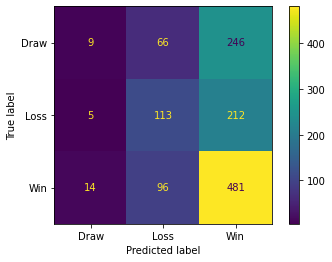

In [43]:
from sklearn.metrics import f1_score

clf = LogisticRegression(C=0.1, solver='newton-cg', max_iter=1000)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=y_encoder.classes_)
disp.plot()
f1_score(y_test, preds, average='macro'), accuracy_score(y_test, preds)

## Support Vector Machine

In [44]:
from sklearn.svm import SVC

accs = {}
for train_ix, test_ix in cv.split(X_train):
  X_train_cv, X_test_cv = X_train[train_ix], X_train[test_ix]
  y_train_cv, y_test_cv = y_train[train_ix], y_train[test_ix]
  svm = SVC(random_state=0)
  params = {'C':[0.001,0.1,10,100,10e3], 
            'gamma':[0.1,0.01]}
  clf = GridSearchCV(svm, params, cv = 3)
  result = clf.fit(X_train_cv, y_train_cv)
  best_model = clf.best_estimator_
  preds = best_model.predict(X_test_cv)
  acc = accuracy_score(y_test_cv, preds)
  accs[acc] = result.best_params_
print(accs)

{0.4987919463087248: {'C': 10, 'gamma': 0.01}, 0.4840268456375839: {'C': 10, 'gamma': 0.01}, 0.49033297529538133: {'C': 10, 'gamma': 0.01}}


(0.3621933174752636, 0.5)

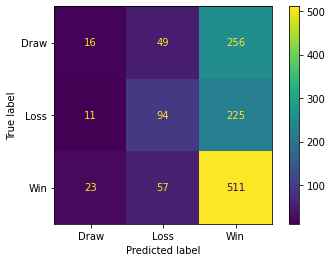

In [45]:
clf = SVC(C=10, gamma=0.01)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=y_encoder.classes_)
disp.plot()
f1_score(y_test, preds, average='macro'), accuracy_score(y_test, preds)

## KNearestNeighbors

In [46]:
from sklearn.neighbors import KNeighborsClassifier


accs = {}
for train_ix, test_ix in cv.split(X_train):
  X_train_cv, X_test_cv = X_train[train_ix], X_train[test_ix]
  y_train_cv, y_test_cv = y_train[train_ix], y_train[test_ix]
  knn = KNeighborsClassifier(n_jobs=-1)
  params = {'algorithm':['ball_tree', 'kd_tree', 'brute'], 
            'leaf_size': [20, 30, 40]}
  clf = GridSearchCV(knn, params, cv = 3)
  result = clf.fit(X_train_cv, y_train_cv)
  best_model = clf.best_estimator_
  preds = best_model.predict(X_test_cv)
  acc = accuracy_score(y_test_cv, preds)
  accs[acc] = result.best_params_
print(accs)

{0.3908724832214765: {'algorithm': 'ball_tree', 'leaf_size': 40}, 0.39946308724832214: {'algorithm': 'kd_tree', 'leaf_size': 40}, 0.39876476906552094: {'algorithm': 'brute', 'leaf_size': 20}}


(0.36572071392382083, 0.3969404186795491)

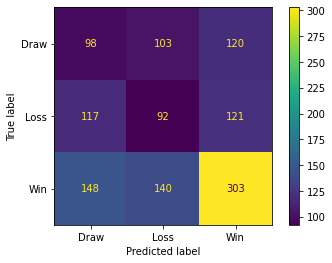

In [47]:
clf = KNeighborsClassifier(algorithm= 'kd_tree', leaf_size = 40, n_jobs=-1)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=y_encoder.classes_)
disp.plot()
f1_score(y_test, preds, average='macro'), accuracy_score(y_test, preds)